<span style="color:darkblue; font-weight:bold; font-size:20px; font-family:Montserrat;">Convolutional Neural Networks and Data Augmentation on CIFAR-10</span><br>
<span style="color:black; font-size:16px; font-family:Montserrat;">By: Ons Kharrat</span>

In [1]:
# Cell 1 — Environment check & reproducibility
import os, random, numpy as np, tensorflow as tf

SEED = 42  # keep constant across runs for fair comparisons
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))

2025-11-16 10:57:00.999885: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763290621.220329      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763290621.279135      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

TensorFlow version: 2.18.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
# Cell 2 — Load CIFAR-10 and prepare splits
import tensorflow as tf
import numpy as np

# Load CIFAR-10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize to [0,1]
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32")  / 255.0
y_train = y_train.squeeze().astype("int64")
y_test  = y_test.squeeze().astype("int64")

# Make a validation split from the tail of the training set (deterministic)
VAL_SIZE = 5000
x_val, y_val = x_train[-VAL_SIZE:], y_train[-VAL_SIZE:]
x_train, y_train = x_train[:-VAL_SIZE], y_train[:-VAL_SIZE]

# Class names (for later CM/plots)
CIFAR10_CLASSES = np.array([
    "airplane","automobile","bird","cat","deer",
    "dog","frog","horse","ship","truck"
])

print("Train:", x_train.shape, y_train.shape, x_train.dtype, y_train.dtype)
print("Val:  ", x_val.shape,   y_val.shape,   x_val.dtype,   y_val.dtype)
print("Test: ", x_test.shape,  y_test.shape,  x_test.dtype,  y_test.dtype)
print("Classes:", CIFAR10_CLASSES.tolist())

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Train: (45000, 32, 32, 3) (45000,) float32 int64
Val:   (5000, 32, 32, 3) (5000,) float32 int64
Test:  (10000, 32, 32, 3) (10000,) float32 int64
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [3]:
# ==============================================================
# Cell 3 — Build data pipelines for CIFAR-10 (no augmentation yet)
# ==============================================================

# AUTOTUNE allows TensorFlow to automatically tune the number of parallel calls 
# and prefetching to speed up input pipelines.
AUTOTUNE = tf.data.AUTOTUNE  

# Mini-batch size: 128 is a good balance between speed and stability.
BATCH = 128  

def make_ds(x, y, training=False):
    """
    Create a tf.data.Dataset pipeline.
    
    Args:
        x (np.ndarray): Image data, shape (N, 32, 32, 3).
        y (np.ndarray): Labels, shape (N,).
        training (bool): If True, shuffle the dataset before batching.

    Returns:
        tf.data.Dataset: A dataset ready for training/evaluation.
    """
    # Step 1: Create a Dataset from numpy arrays
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    
    # Step 2: Shuffle only during training to avoid overfitting
    if training:
        ds = ds.shuffle(buffer_size=len(x), seed=SEED)  
    
    # Step 3: Batch and prefetch (pipeline optimization)
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)  
    
    return ds

# Create the datasets
ds_train = make_ds(x_train, y_train, training=True)  # with shuffling
ds_val   = make_ds(x_val, y_val)                     # no shuffle
ds_test  = make_ds(x_test, y_test)                   # no shuffle

# --------------------------------------------------------------
# Inspect one batch to confirm shapes and dtypes
# --------------------------------------------------------------
xb, yb = next(iter(ds_train))
print("Batch images:", xb.shape, xb.dtype)   # Expected: (128, 32, 32, 3) float32
print("Batch labels:", yb.shape, yb.dtype)   # Expected: (128,) int64

I0000 00:00:1763290645.701198      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763290645.701928      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Batch images: (128, 32, 32, 3) <dtype: 'float32'>
Batch labels: (128,) <dtype: 'int64'>


In [4]:
# ==============================================================
# Cell 4 — Define a compact Custom CNN for CIFAR-10
# --------------------------------------------------------------
# Design goals:
# 1) Keep it small enough to train quickly in class
# 2) Use standard Conv → BatchNorm → ReLU → MaxPool blocks
# 3) GlobalAveragePooling to reduce parameters vs. big Dense layers
# ==============================================================

from tensorflow import keras
from tensorflow.keras import layers as L

NUM_CLASSES = 10
IMG_SHAPE   = (32, 32, 3)

def ConvBlock(filters: int) -> keras.Sequential:
    """
    A single convolutional processing block:
      Conv2D(filters, 3x3, same) → BatchNorm → ReLU → MaxPool(2x2)
    Rationale:
      - 3x3 conv is a sweet spot for local feature extraction
      - BatchNorm stabilizes and speeds up training
      - ReLU is a standard non-linearity
      - MaxPool halves spatial size → reduces compute, increases receptive field
    """
    return keras.Sequential([
        L.Conv2D(filters, kernel_size=3, padding="same", use_bias=False),
        L.BatchNormalization(),
        L.ReLU(),
        L.MaxPool2D(pool_size=2, strides=2)
    ])

def build_custom_cnn(dropout_rate: float = 0.30) -> keras.Model:
    """
    Build the end-to-end classifier.
    Layout (feature dims in comments refer to CIFAR-10 32x32 inputs):
      Input (32x32x3)
      → ConvBlock(32)   → (16x16x32)
      → ConvBlock(64)   → (8x8x64)
      → ConvBlock(128)  → (4x4x128)
      → GlobalAveragePooling2D      # compress (H,W) to 1x1 by averaging
      → Dropout(dropout_rate)       # regularization
      → Dense(10, softmax)          # class probabilities
    """
    inputs = L.Input(shape=IMG_SHAPE)

    x = ConvBlock(32)(inputs)
    x = ConvBlock(64)(x)
    x = ConvBlock(128)(x)

    x = L.GlobalAveragePooling2D()(x)
    x = L.Dropout(dropout_rate)(x)

    outputs = L.Dense(NUM_CLASSES, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="CustomCNN_CIFAR10")

    # -------------------------------
    # Compile
    # -------------------------------
    # - Adam: robust, quick convergence for class labs
    # - Loss: sparse categorical CE (labels are int class ids, not one-hot)
    # - Metrics: accuracy for easy interpretation
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Instantiate and show the model
model_base = build_custom_cnn(dropout_rate=0.30)

# Print a concise layer-by-layer summary with parameter counts
model_base.summary()

# For reference, also print total trainable parameter count explicitly
total_params = np.sum([np.prod(v.shape) for v in model_base.trainable_weights])
print(f"\nTotal trainable parameters: {total_params:,}")

Model: "CustomCNN_CIFAR10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 16, 16, 32)     │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 8, 8, 64)       │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 4, 4, 128)      │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,210 (371.91 KB)

 Trainable params: 94,762 (370.16 KB)

 Non-trainable params: 448 (1.75 KB)


Total trainable parameters: 94,762


In [5]:
# ==============================================================
# Cell 5 — Train the baseline model (NO augmentation)
# ==============================================================

# Training setup:
# - We will train our Custom CNN on the CIFAR-10 dataset
# - Goal: learn how well the model performs *without* data augmentation
# - Later, we’ll compare this to training *with* augmentation

# --------------------------------------------------------------
# Callbacks: "helpers" that monitor training and react automatically
# --------------------------------------------------------------

from tensorflow import keras

callbacks = [
    # 1. ReduceLROnPlateau
    #    If validation loss stops improving for 'patience' epochs,
    #    cut the learning rate in half to allow finer learning.
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",   # what metric to watch
        factor=0.5,           # how much to reduce LR by
        patience=1,           # wait this many epochs before reducing
        verbose=1,
        min_lr=1e-5           # don’t go below this LR
    ),
    
    # 2. EarlyStopping
    #    If validation loss doesn’t improve for 'patience' epochs,
    #    stop training early to avoid overfitting / wasting time.
    #    Restore the weights from the epoch with the best val_loss.
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=2,
        restore_best_weights=True,
        verbose=1
    )
]

# --------------------------------------------------------------
# Training loop
# --------------------------------------------------------------

EPOCHS_BASE = 8  # short training for class demo (can be increased if time/resources allow)

history_base = model_base.fit(
    ds_train,              # training dataset
    validation_data=ds_val,# validation dataset
    epochs=EPOCHS_BASE,    # number of epochs (full passes through data)
    callbacks=callbacks,   # add our training helpers
    verbose=1              # print compact logs per epoch
)

# --------------------------------------------------------------
# Save best validation accuracy for later comparison (vs. augmentation)
# --------------------------------------------------------------
best_val_acc_base = max(history_base.history["val_accuracy"])
print(f"\n[Baseline] Best Validation Accuracy: {best_val_acc_base:.4f}")

Epoch 1/8


I0000 00:00:1763290652.285149      61 service.cc:148] XLA service 0x7e687c02f350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763290652.285834      61 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763290652.285855      61 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763290652.628517      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


 27/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1782 - loss: 2.4425

I0000 00:00:1763290655.716103      61 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


352/352 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.3563 - loss: 1.7991 - val_accuracy: 0.2210 - val_loss: 2.8612 - learning_rate: 0.0010
Epoch 2/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5342 - loss: 1.3011 - val_accuracy: 0.5132 - val_loss: 1.3660 - learning_rate: 0.0010
Epoch 3/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5755 - loss: 1.1786
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5756 - loss: 1.1786 - val_accuracy: 0.4978 - val_loss: 1.4603 - learning_rate: 0.0010
Epoch 4/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6170 - loss: 1.0747 - val_accuracy: 0.5038 - val_loss: 1.3482 - learning_rate: 5.0000e-04
Epoch 5/8
348/352 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6347 - loss: 1.0330
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6348 - loss: 1.0329 - val_accurac

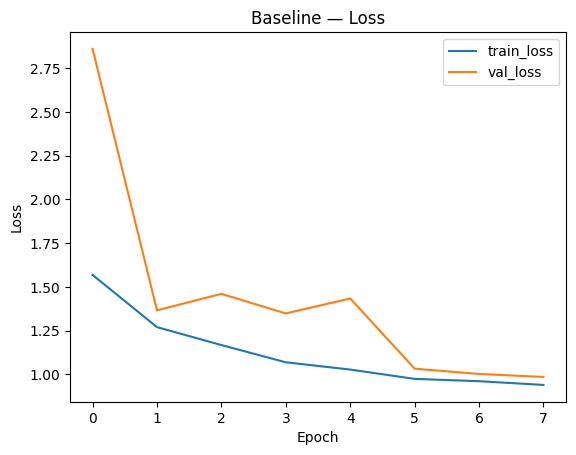

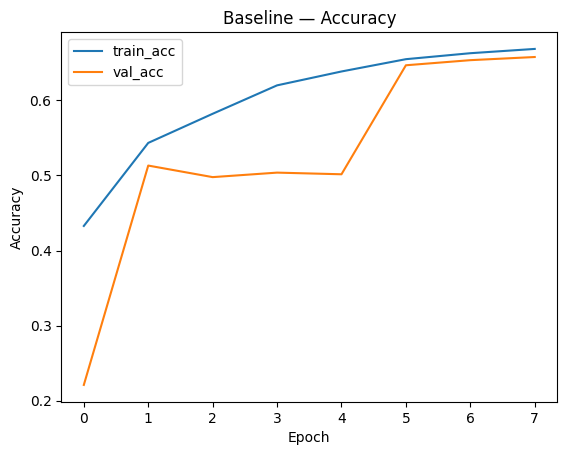

In [6]:
# ==============================================================
# Cell 6 — Plot training curves for the BASELINE model
# --------------------------------------------------------------
# Why plot? To visually diagnose learning dynamics:
#  - Diverging train vs. val = overfitting risk
#  - Flat curves = underfitting or LR too low/high
# ==============================================================

import matplotlib.pyplot as plt

h = history_base.history  # dictionary: keys like 'loss', 'accuracy', 'val_loss', 'val_accuracy'

# 1) Loss curve
plt.figure()
plt.plot(h["loss"],      label="train_loss")
plt.plot(h["val_loss"],  label="val_loss")
plt.title("Baseline — Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 2) Accuracy curve
plt.figure()
plt.plot(h["accuracy"],      label="train_acc")
plt.plot(h["val_accuracy"],  label="val_acc")
plt.title("Baseline — Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [7]:
# ==============================================================
# Cell 7 — Baseline TEST evaluation
# --------------------------------------------------------------
# Purpose: fix a reference accuracy adding augmentation.
# ==============================================================

test_loss_base, test_acc_base = model_base.evaluate(ds_test, verbose=0)
print({"test_loss_base": float(test_loss_base), "test_acc_base": float(test_acc_base)})

{'test_loss_base': 0.9991636872291565, 'test_acc_base': 0.6466000080108643}


Augmented batch images: (128, 32, 32, 3) <dtype: 'float32'>
Augmented batch labels: (128,) <dtype: 'int64'>


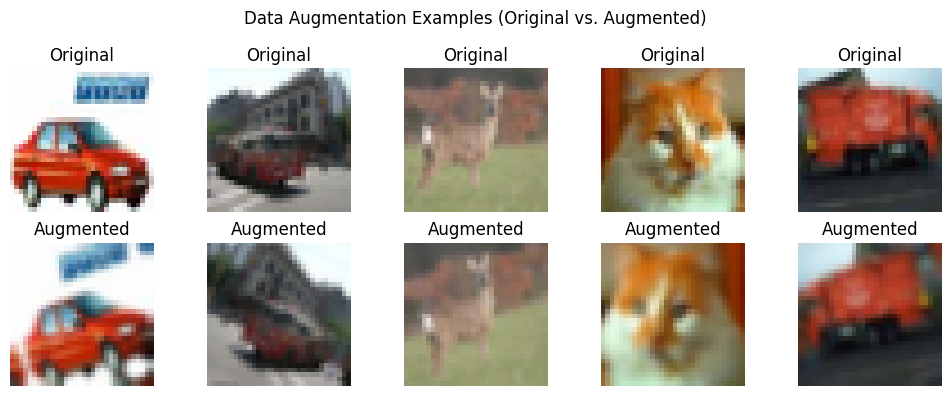

In [8]:
# ==============================================================
# Cell 8 — Data Augmentation + Visualization
# ==============================================================

# Define the augmentation pipeline
# NOTE: Our images are already normalized to [0,1] earlier, which is fine.
# Keep augmentations modest for CIFAR-10 so we don't distort semantics too much.
augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),   # flips left/right
    tf.keras.layers.RandomRotation(0.08),       # rotate ±8% of 180° (~±14.4°)
    tf.keras.layers.RandomZoom(0.10)            # zoom ±10%
])

def make_ds_aug(x, y):
    """
    Create a dataset with augmentation applied to each image.
    Augmentation is applied *on the fly* at training time.
    """
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    ds = ds.shuffle(buffer_size=len(x), seed=SEED)

    # Apply augmentation in the map function
    def _map(img, lbl):
        # IMPORTANT: 'training=True' forces the layers to sample randomness
        img = augment(img, training=True)
        return img, lbl

    ds = ds.map(_map, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

# Build augmented training dataset
ds_train_aug = make_ds_aug(x_train, y_train)

# Inspect shapes
xb_aug, yb_aug = next(iter(ds_train_aug))
print("Augmented batch images:", xb_aug.shape, xb_aug.dtype)
print("Augmented batch labels:", yb_aug.shape, yb_aug.dtype)

# --------------------------------------------------------------
# Visualization: original vs. augmented samples
# --------------------------------------------------------------
import matplotlib.pyplot as plt

# Take 5 random indices from training set
idxs = np.random.choice(len(x_train), size=5, replace=False)

plt.figure(figsize=(10, 4))
for i, idx in enumerate(idxs):
    # Original image
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[idx])
    plt.axis("off")
    plt.title("Original")

    # Augmented image (apply pipeline once)
    aug_img = augment(x_train[idx], training=True).numpy()
    plt.subplot(2, 5, i+6)
    plt.imshow(aug_img)
    plt.axis("off")
    plt.title("Augmented")

plt.suptitle("Data Augmentation Examples (Original vs. Augmented)")
plt.tight_layout()
plt.show()

In [9]:
# ==============================================================
# Cell 9 — Train the AUGMENTED model (same architecture as baseline)
# ==============================================================

from tensorflow import keras
from tensorflow.keras import layers as L

# Rebuild the exact same network from the baseline (fresh weights)
def ConvBlock(filters: int) -> keras.Sequential:
    return keras.Sequential([
        L.Conv2D(filters, kernel_size=3, padding="same", use_bias=False),
        L.BatchNormalization(),
        L.ReLU(),
        L.MaxPool2D(pool_size=2, strides=2)
    ])

def build_custom_cnn(dropout_rate: float = 0.30) -> keras.Model:
    inputs = L.Input(shape=(32, 32, 3))
    x = ConvBlock(32)(inputs)
    x = ConvBlock(64)(x)
    x = ConvBlock(128)(x)
    x = L.GlobalAveragePooling2D()(x)
    x = L.Dropout(dropout_rate)(x)
    outputs = L.Dense(10, activation="softmax")(x)
    model = keras.Model(inputs, outputs, name="CustomCNN_CIFAR10_AUG")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

model_aug = build_custom_cnn(dropout_rate=0.30)
model_aug.summary()

# Use the same callbacks (fair A/B)
callbacks_aug = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=1, verbose=2, min_lr=1e-5
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=2, restore_best_weights=True, verbose=1
    )
]

EPOCHS_AUG = 8  # keep identical to baseline for now

history_aug = model_aug.fit(
    ds_train_aug,          # <— augmented pipeline
    validation_data=ds_val,
    epochs=EPOCHS_AUG,
    callbacks=callbacks_aug,
    verbose=1
)

best_val_acc_aug = max(history_aug.history["val_accuracy"])
print(f"\n[Augmented] Best Validation Accuracy: {best_val_acc_aug:.4f}")

Model: "CustomCNN_CIFAR10_AUG"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 16, 16, 32)     │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 8, 8, 64)       │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 4, 4, 128)      │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,210 (371.91 KB)

 Trainable params: 94,762 (370.16 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.3136 - loss: 1.9126 - val_accuracy: 0.2196 - val_loss: 2.6147 - learning_rate: 0.0010
Epoch 2/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4593 - loss: 1.4971 - val_accuracy: 0.4334 - val_loss: 1.6812 - learning_rate: 0.0010
Epoch 3/8
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5066 - loss: 1.3586
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
352/352 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.5067 - loss: 1.3585 - val_accuracy: 0.4486 - val_loss: 1.8402 - learning_rate: 0.0010
Epoch 4/8
352/352 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.5428 - loss: 1.2774 - val_accuracy: 0.5574 - val_loss: 1.2620 - learning_rate: 5.0000e-04
Epoch 5/8
351/352 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5548 - loss: 1.2360
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
352/352 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.5548 - loss: 

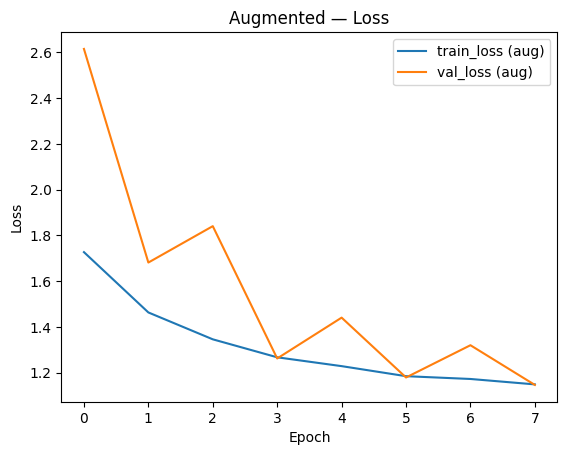

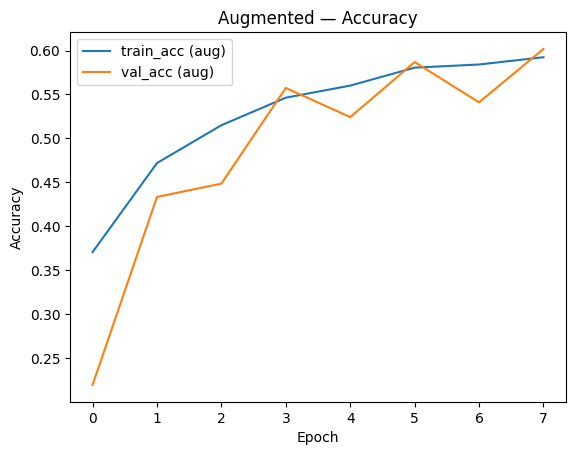

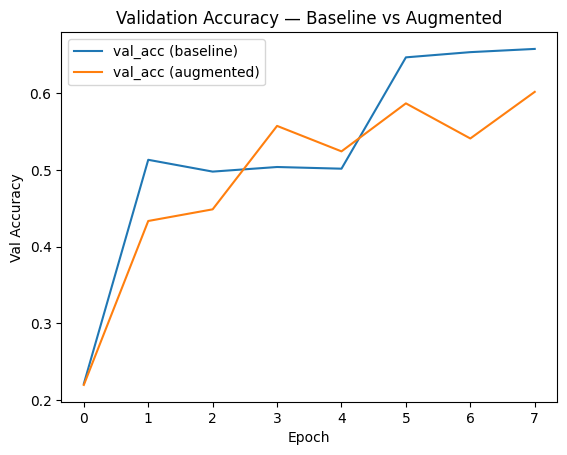

In [10]:
# ==============================================================
# Cell 10 — Plot AUGMENTED training curves + compare to baseline
# --------------------------------------------------------------
# We visualize the augmented model's training dynamics.
# Then, if 'history_base' exists, we overlay validation accuracy
# to compare (baseline vs. augmented).
# ==============================================================

import matplotlib.pyplot as plt

h_aug = history_aug.history  # keys: 'loss', 'accuracy', 'val_loss', 'val_accuracy'

# 1) Loss curve (augmented)
plt.figure()
plt.plot(h_aug["loss"],     label="train_loss (aug)")
plt.plot(h_aug["val_loss"], label="val_loss (aug)")
plt.title("Augmented — Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

# 2) Accuracy curve (augmented)
plt.figure()
plt.plot(h_aug["accuracy"],     label="train_acc (aug)")
plt.plot(h_aug["val_accuracy"], label="val_acc (aug)")
plt.title("Augmented — Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.show()

# 3) Optional overlay: baseline vs augmented (validation accuracy only)
try:
    h_base = history_base.history
    plt.figure()
    plt.plot(h_base["val_accuracy"], label="val_acc (baseline)")
    plt.plot(h_aug["val_accuracy"],  label="val_acc (augmented)")
    plt.title("Validation Accuracy — Baseline vs Augmented")
    plt.xlabel("Epoch"); plt.ylabel("Val Accuracy"); plt.legend(); plt.show()
except NameError:
    print("Baseline history not found; skipping overlay.")

In [11]:
# ==============================================================
# Cell 11 — Test evaluation: baseline vs augmented
# --------------------------------------------------------------
# Purpose: Compare how each model does on the *held-out test set*.
# ==============================================================

# 1) Evaluate augmented model on test set
test_loss_aug, test_acc_aug = model_aug.evaluate(ds_test, verbose=0)

# 2) Print side-by-side comparison
print("===== CIFAR-10 Test Set Results =====")
print(f"Baseline:  test_acc = {test_acc_base:.4f}, test_loss = {test_loss_base:.4f}")
print(f"Augmented: test_acc = {test_acc_aug:.4f}, test_loss = {test_loss_aug:.4f}")

# Store for later reporting (confusion matrix, reflection)
results = {
    "baseline_acc": float(test_acc_base),
    "augmented_acc": float(test_acc_aug),
    "baseline_loss": float(test_loss_base),
    "augmented_loss": float(test_loss_aug)
}
results

===== CIFAR-10 Test Set Results =====
Baseline:  test_acc = 0.6466, test_loss = 0.9992
Augmented: test_acc = 0.5901, test_loss = 1.1533


{'baseline_acc': 0.6466000080108643,
 'augmented_acc': 0.5900999903678894,
 'baseline_loss': 0.9991636872291565,
 'augmented_loss': 1.153291940689087}

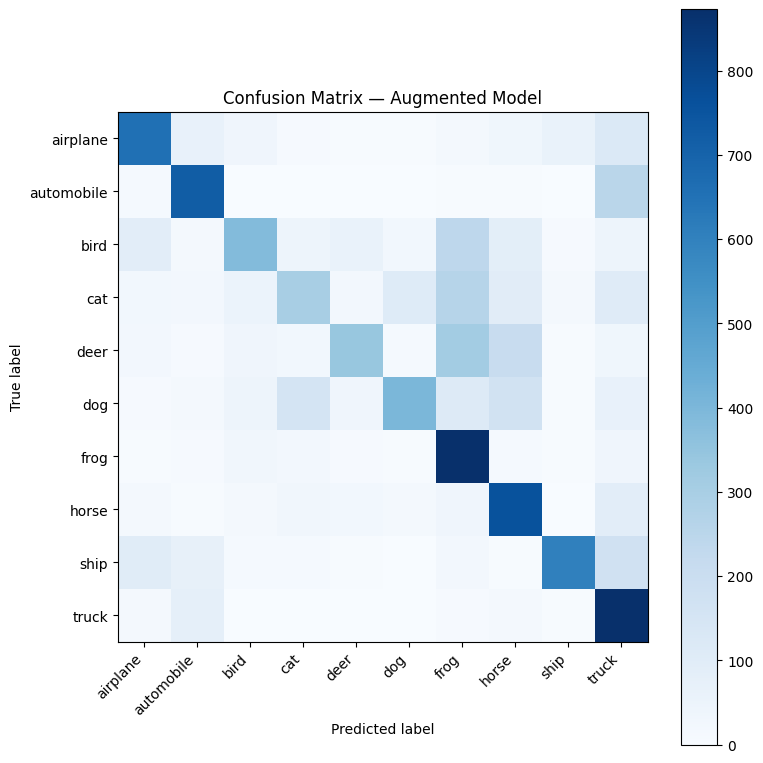

In [12]:
# ==============================================================
# Cell 12 — Confusion Matrix for the Augmented Model
# --------------------------------------------------------------
# Purpose: See which classes are most confused under augmentation.
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Step 1: Collect predictions
y_true, y_pred = [], []
for xb, yb in ds_test:
    preds = model_aug.predict(xb, verbose=0)
    y_true.extend(yb.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Step 2: Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Plot confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix — Augmented Model")
plt.colorbar()

tick_marks = np.arange(len(CIFAR10_CLASSES))
plt.xticks(tick_marks, CIFAR10_CLASSES, rotation=45, ha="right")
plt.yticks(tick_marks, CIFAR10_CLASSES)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()